In [50]:
import time
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import minorminer
import networkx as nx
import numpy as np
from random import sample
# from embera.architectures import generators
# from embera.architectures import drawing
# from embera.preprocess.complete_diffusion_placer import find_candidates
# from embera.preprocess.complete_diffusion_placer_pegasus import find_candidates as find_candidates_pegasus
from contextlib import redirect_stdout
import csv 

In [4]:
topology_chimera = dnx.chimera_graph(16)
topology_pegasus = dnx.pegasus_graph(16)
topology_zephyr = dnx.zephyr_graph(15)

topologies = [topology_chimera, topology_pegasus, topology_zephyr]
algs = ["mm", "clique", "la", "la_no_mig"]

In [5]:
def qubits_lower_bound(num_vertices, degree, topology, count_border_edges=False):
    """Calculates a lower bound on the number of qubits needed to embed a regular graph.

    Args:
        num_vertices: The number of vertices, as either an int or a numpy array.
        degree: The degree, assumed to be equal for all vertices, as an int or a numpy array.
        topology: The topology on which to embed the graph.
        count_border_edges: Whether to add a term for border edges. Only works for Chimera.

    Returns:
        A lower bound on the number of qubits needed. If either num_vertices or degree is an array,
        so is the result, otherwise it is a scalar.
    """
    # Find the number of couplers per qubit. 6 for Chimera, 15 for Pegasus or 20 for Zephyr
    if topology == topology_chimera:
        topology_degree = 6
    elif topology == topology_pegasus:
        topology_degree = 15
    elif topology == topology_zephyr:
        topology_degree = 20

    num_vertices = num_vertices[1:]
    degree = degree[1:]

    bound = np.maximum(num_vertices * np.ceil((degree - 2) / (topology_degree - 2)), num_vertices)
    iters = 0
    while count_border_edges:
        old_bound = bound
        cells = np.ceil(bound / 8)
        size = np.ceil(np.sqrt(cells))
        border_edges = (size + np.ceil(cells / size)) * 2 * 4
        bound = np.maximum(num_vertices * np.ceil((degree - 2 + border_edges / num_vertices) / (topology_degree - 2)), num_vertices)
        iters += 1
        if (bound == old_bound).all():
            print(f"{iters} iterations")
            break
            
    bound = np.insert(bound, 0, 0)
    return bound

In [6]:
def find_max_diameter(C, embedding):
    """Finds the longest qubit chain diameter for an embedding.

    Args:
        C: The topology onto which a graph is embedded.
        embedding: A mapping of logical nodes to qubits.

    Returns:
        The length of the longest qubit chain diameter in the embedding.
    """
    chain_diameters = np.zeros(len(embedding))

    for k, chain in enumerate(embedding.values()):
        if (len(chain) == 1):
            continue

        chain_edges = []
        
        for edge in C.edges:
            if edge[0] in chain and edge[1] in chain:
                chain_edges.append(edge)
    
        E = nx.Graph(chain_edges)
        chain_diameters[k] = nx.diameter(E)

    return max(chain_diameters)

In [7]:
def prune(G, node_yield=1.0, edge_yield=1.0):
    """From embera code. Simulates a broken topology.

    Args:
        G: The topology to be broken.
        node_yield: Rate of functional qubits.
        edge_yield: Rate of functional couplers.

    Returns:
        A broken topology.
    """
    # Remove nodes
    nodes = list(G.nodes)
    num_node_faults = len(nodes) - round(len(nodes) * node_yield)
    randnodes = sample(nodes, int(num_node_faults))
    G.remove_nodes_from(randnodes)
    
    # Remove edges
    edges = list(G.edges)
    num_edge_faults = len(edges) - round(len(edges) * edge_yield)
    randedges = sample(edges, int(num_edge_faults))
    G.remove_edges_from(randedges)
    
    return G

In [30]:
def clique_embed(G, topology):
    
    start = time.process_time()
    embedding = minorminer.busclique.find_clique_embedding(len(G), topology)
    timing = time.process_time() - start
    qubits = sum(map(len, embedding.values()))
    maxchain = max(map(len, embedding.values()))
    max_diameter = find_max_diameter(topology, embedding)
    
    return qubits, maxchain, max_diameter, timing

In [31]:
def mm_embed(G, topology):
    
    start = time.process_time()
    embedding = minorminer.find_embedding(G, topology)
    timing = time.process_time() - start

    return embedding, timing

In [49]:
def la_embed(G, topology, alg):
    """ Returns a layout-aware embedding. Requires embera setup. """

    S_edgelist = list(G.edges())

    # convert complete nodes to coordinates
    if topology == topology_pegasus:
        S_coordlist = [((0,0,0),(0,0,0))]*len(S_edgelist)
        
        for i,edge in enumerate(S_edgelist):
            x,y = edge
            S_coordlist[i] = ((0,x,x),(0,y,y))
    else: # Chimera or Zephyr
        S_coordlist = [((0,0),(0,0))]*len(S_edgelist)
        
        for i,edge in enumerate(S_edgelist):
            x,y = edge
            S_coordlist[i] = ((x,x),(y,y))

    # Layout of the problem graph
    layout = {v:v for e in S_coordlist for v in e}
    
    if topology == topology_chimera:
        Tg = generators.dw2000q_graph() # D-Wave 2000Q annealer
    elif topology == topology_pegasus:
        Tg = generators.p16_graph() # 3# tile coords
    else: # Zephyr
        Tg = generators.z15_graph()
        
    T_edgelist = list(Tg.edges())
    
    if alg == "la":
        mig = True
    else:
        mig = False
        
    # Find a global placement for problem graph
    if topology == topology_pegasus:
        start = time.process_time()
        candidates = find_candidates_pegasus(S_coordlist, Tg, layout=layout, enable_migration=mig)
    else: # Chimera or Zephyr
        start = time.process_time()
        candidates = find_candidates(S_coordlist, Tg, layout=layout, enable_migration=mig)
    # Find a minor-embedding using the initial chains from global placement
    embedding = find_embedding(S_coordlist, T_edgelist, initial_chains=candidates)
    timing = time.process_time() - start

    return embedding, timing

In [33]:
def embed_graph(G, topology, alg, m=3):
    """ Attempts to embed a graph G.

    Args:
        G: The source graph to embed.
        topology: The topology on which to embed the graph.
        alg: The embedding algorithm to be used.
        m: The number of trials.
        
    Returns: 
        qubits: An array of size m containing the number of qubits required to embed the graph.
        maxchain: An array of size m containing the greatest qubit chain size in each embedding.
        max_diameter: An array of size m containing the greatest qubit chain diameter in each embedding.
        timing: An array of size m containing the time taken to complete each embedding.
    """

    # if not topology in topologies:
    #     exit("error: invalid topology")
    if not alg in algs:
        exit("error: invalid algorithm")

    if alg == "clique": # multiple trials not necessary
        return clique_embed(G, topology)
    
    qubits = np.zeros(m)
    maxchain = np.zeros(m)
    max_diameter = np.zeros(m)
    timing = np.zeros(m)

    for k in range(m):
        if alg == "mm":
            embedding, timing[k] = mm_embed(G, topology)
        else: # LA
            embedding, timing[k] = la_embed(G, topology, alg)

        if not embedding: # embedding failed
            continue

        qubits[k] = sum(map(len, embedding.values()))
        maxchain[k] = max(map(len, embedding.values()))
        max_diameter[k] = find_max_diameter(topology, embedding)

    return qubits, maxchain, max_diameter, timing

In [34]:
def complete_over_N(topology, alg, N, m=3, qubit_yield=1.0):
    """ Generates a complete graph of every size from 1 to N nodes, and attempts to embed it m times.

    Args:
        topology: The topology on which to embed the graph.
        alg: The embedding algorithm to be used.
        N: The maximum graph size/number of nodes for the source graph.
        m: The number of trials per source graph.
        qubit_yield: The rate of functional qubits.
        
    Returns: 
        qubits: An Nxm array containing the number of qubits required for each embedding for each graph size.
        maxchain: An Nxm array containing the greatest qubit chain size for each embedding for each graph size.
        max_diameter: An Nxm array containing the greatest qubit chain diameter for each embedding for each graph size.
        timing: An Nxm array containing the time taken for each embedding for each graph size.
    """

    if not topology in topologies:
        exit("error: invalid topology")
    if not alg in algs:
        exit("error: invalid algorithm")
    
    qubits = np.zeros((N,m))
    maxchain = np.zeros((N,m))
    max_diameter = np.zeros((N,m))
    timing = np.zeros((N,m))
    
    for n in ns:
        if n==0:
            continue
            
        G = nx.complete_graph(n)

        # introduce qubit faults
        topology_pruned = topology.copy()
        prune(topology_pruned, qubit_yield)
        if not topology_pruned.nodes: # complete topology broken
            continue
        
        qubits[n], maxchain[n], max_diameter[n], timing[n] = embed_graph(G, topology_pruned, alg, m)

    return qubits, maxchain, max_diameter, timing

In [35]:
def fixed_degree_over_deg(topology, alg, N, m=3, qubit_yield=1.0):
    """ Generates a graph with N nodes and uniform degree 0 to N-1, and attempts to embed it m times.

    Args:
        topology: The topology on which to embed the graph.
        alg: The embedding algorithm to be used.
        N: The graph size/number of nodes for the source graph.
        m: The number of trials per source graph.
        qubit_yield: The rate of functional qubits.
        
    Returns: 
        qubits: A 2D array containing the number of qubits required for each embedding for each degree.
        maxchain: A 2D array containing the greatest qubit chain size for each embedding for each degree.
        max_diameter: A 2D array containing the greatest qubit chain diameter for each embedding for each degree.
        timing: A 2D array containing the time taken for each embedding for each degree.
    """

    if not topology in topologies:
        exit("error: invalid topology")
    if not alg in algs:
        exit("error: invalid algorithm")
    
    qubits = np.zeros((N,m))
    maxchain = np.zeros((N,m))
    max_diameter = np.zeros((N,m))
    timing = np.zeros((N,m))
    
    for deg in range(N):
        G = nx.random_regular_graph(d=deg, n=N)

        # introduce qubit faults
        topology_pruned = topology.copy()
        prune(topology_pruned, qubit_yield)
        if not topology_pruned.nodes: # topology completely broken
            continue
        
        qubits[n], maxchain[n], max_diameter[n], timing[n] = embed_graph(G, topology_pruned, alg, m)

    return qubits, maxchain, max_diameter, timing

In [36]:
def complete_over_pct(topology, alg, pcts, n=20, m=3):
    """ Generates a complete graph with n nodes, and attempts to embed it m times, for each pct in pcts qubit faults.

    Args:
        topology: The topology on which to embed the grap,h.
        alg: The embedding algorithm to be used.
        n: The graph size/number of nodes for the source graph.
        m: The number of trials per step.
        pcts: An array of qubit fault percentages.
        
    Returns: 
        qubits: An Nxm array containing the number of qubits required for each embedding for each step.
        maxchain: An Nxm array containing the greatest qubit chain size for each embedding for each step.
        max_diameter: An Nxm array containing the greatest qubit chain diameter for each embedding for each step.
        timing: An Nxm array containing the time taken for each embedding for each step.
    """

    if not topology in topologies:
        exit("error: invalid topology")
    if not alg in algs:
        exit("error: invalid algorithm")

    qubits = np.zeros((len(pcts),m))
    maxchain = np.zeros((len(pcts),m))
    max_diameter = np.zeros((len(pcts),m))
    timing = np.zeros((len(pcts),m))

    for i, pct in enumerate(pcts):
        G = nx.complete_graph(n)
        
        topology_pruned = topology.copy()
        prune(topology_pruned, 1-pct)

        if not topology_pruned.nodes: # complete topology broken
            continue
        
        qubits[i], maxchain[i], max_diameter[i], timing[i] = embed_graph(G, topology_pruned, alg, m)

    return qubits, maxchain, max_diameter, timing

In [37]:
def find_average(arr):
    """ returns an array of averages of sub-arrays """
    return list(sum(sub_arr)/m for sub_arr in arr)

In [38]:
def find_success_rate(arr):
    """ returns an array of rates of non-zero entries in sub-arrays """
    rates = np.zeros(len(arr))
    for i, sub_arr in enumerate(arr):
        success = 0
        total = 0
        for v in sub_arr:
            if v > 0:
                success += 1
            total += 1
        rates[i] = success/total

    return rates

In [47]:
topology = topology_pegasus 
alg = "mm"
N = 60
ns = range(N)
m = 3

## embed a graph
# G = nx.complete_graph(N)
# qubits, maxchain, max_diameter, timing = embed_graph(G, topology, alg, m)

## embed many graphs, varying n or degree
qubit_yield = 1.00
qubits, maxchain, max_diameter, timing = complete_over_N(topology, alg, N, m, qubit_yield)
# qubits, maxchain, max_diameter, timing = fixed_degree_over_deg(topology, alg, N, m, qubit_yield)

## embed many graphs, varying qubit fault rate
# step_size = 0.005
# pcts = np.arange(0, .25, step_size)
# qubits, maxchain, max_diameter, timing = complete_over_pct(topology, alg, pcts, N, m)

qubits_avg = find_average(qubits)
maxchain_avg = find_average(maxchain)
max_diameter_avg = find_average(max_diameter)
timing_avg = find_average(timing)

success_rate = find_success_rate(qubits)

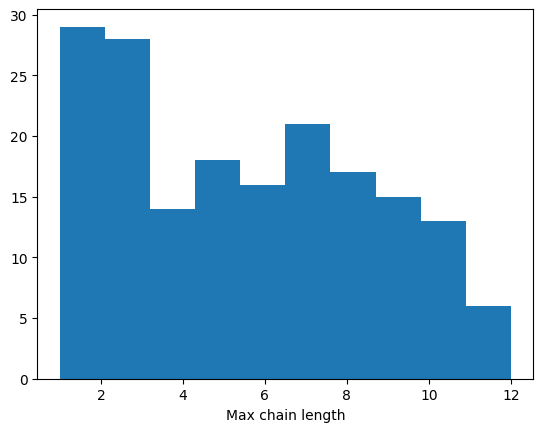

In [48]:
# max chain size histogram
maxchains = maxchain[1:].flatten()
plt.hist(maxchains)
plt.xlabel("Max chain length")
# plt.savefig(f'./output/maxchain-hist-{alg}-{topology.name}-n={N}-{qubit_yield*100}%.png')

In [ ]:
############ plots over pcts ############

Text(0, 0.5, '% success')

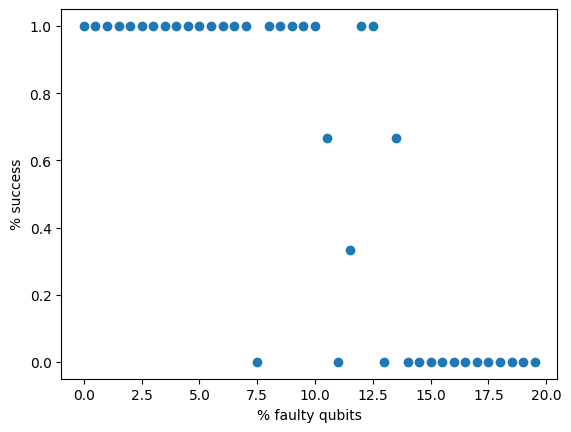

In [21]:
# plot % faulty qubits vs. success rate
plt.scatter(pcts*100, success_rate)
plt.xlabel("% faulty qubits")
plt.ylabel("% success")

Text(0, 0.5, 'Qubits required to embed')

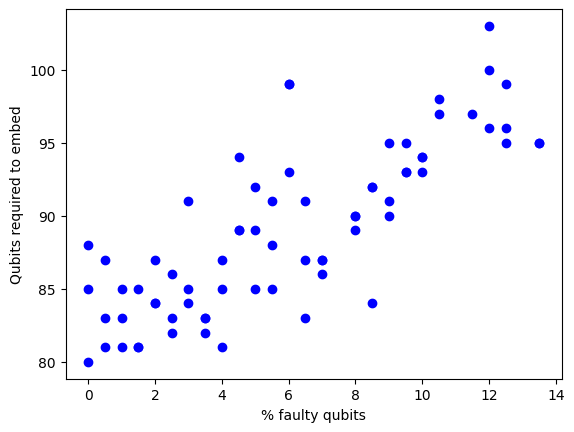

In [57]:
# plot % faulty qubits vs. qubits required for successful embeddings
q = np.transpose(qubits)
q_success = list((y if y>0 else float('nan') for y in x) for x in q) # change all 0-entries (fails) to nan

for i in range(m):
    plt.scatter(pcts*100, list(q_success[i]), color='b')
    
plt.xlabel("% faulty qubits")
plt.ylabel("Qubits required to embed")

Text(0, 0.5, 'Time to complete (s)')

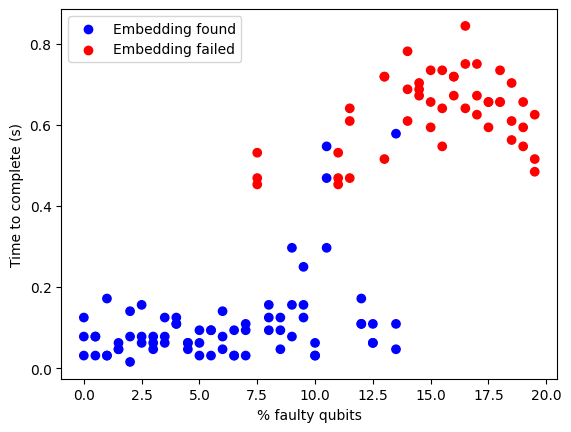

In [48]:
# plot % faulty qubits vs. time to complete
t = np.transpose(timing)
q = np.transpose(qubits)

colors = [['y']*len(pcts)]*m
for i in range(m):
    for k in range(len(pcts)):
        if q[i][k] > 0: # success
            colors[i][k] = 'b'
        else: # fail
            colors[i][k] = 'r'

# legend
plt.scatter([], [], c='b')
plt.scatter([], [], c='r')
plt.legend(['Embedding found', 'Embedding failed'])

for i in range(m):
    plt.scatter(pcts*100, t[i], c=colors[i])
    
plt.xlabel("% faulty qubits")
plt.ylabel("Time to complete (s)")

Text(0, 0.5, 'Maximum chain diameter')

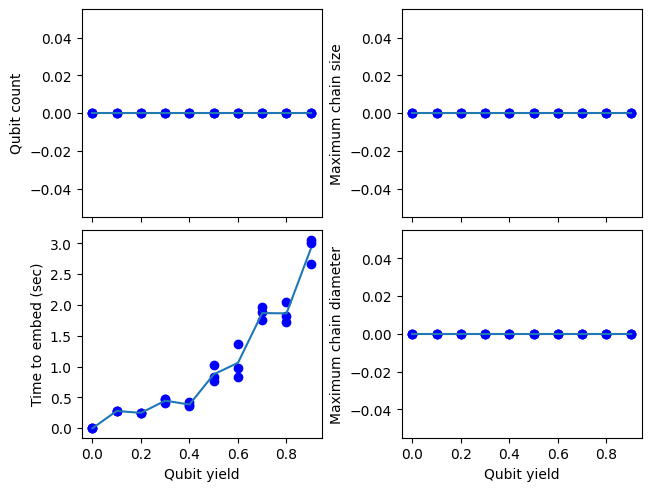

In [138]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, layout="constrained")

# plot qubits
q = np.transpose(qubits)
for k in range(m):
    axs[0,0].scatter(100*pcts, q[k], c='b')
axs[0,0].plot(100*pcts, qubits_avg)

# axs[0,0].set_xlabel("% faulty qubits")
axs[0,0].set_ylabel("Qubit count")

# plot maxchain
c = np.transpose(maxchain)
for k in range(m):
    axs[0,1].scatter(100*pcts, c[k], c='b')
axs[0,1].plot(100*pcts, maxchain_avg)

# axs[0,1].set_xlabel("% faulty qubits")
axs[0,1].set_ylabel("Maximum chain size")

# plot timing
t = np.transpose(timing)
for k in range(m):
    axs[1,0].scatter(100*pcts, t[k], c='b')
axs[1,0].plot(100*pcts, timing_avg)

axs[1,0].set_xlabel("% faulty qubits")
axs[1,0].set_ylabel("Time to embed (sec)")

# plot max diameter
d = np.transpose(max_diameter)
for k in range(m):
    axs[1,1].scatter(100*pcts, d[k], c='b')
axs[1,1].plot(100*pcts, max_diameter_avg)

axs[1,1].set_xlabel("% faulty qubits")
axs[1,1].set_ylabel("Maximum chain diameter")
# fig.savefig(f'./output/{alg}-{topology.name}-{N}-faults-data.png')

In [ ]:
############ plots over N ############

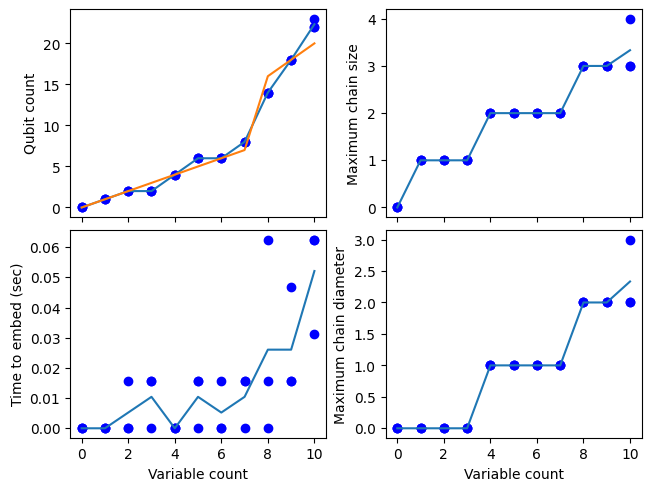

In [46]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, layout="constrained")

degrees = np.array(list(n-1 for n in ns)) # for lower bound

# plot qubits
q = np.transpose(qubits)
for k in range(m):
    axs[0,0].scatter(ns, q[k], c='b')
axs[0,0].plot(ns, qubits_avg)
lower_bound = qubits_lower_bound(ns, degrees, topology, count_border_edges=False)
axs[0,0].plot(ns, lower_bound)

# axs[0,0].set_xlabel("Variable count")
axs[0,0].set_ylabel("Qubit count")

# plot maxchain
c = np.transpose(maxchain)
for k in range(m):
    axs[0,1].scatter(ns, c[k], c='b')
axs[0,1].plot(ns, maxchain_avg)

# axs[0,1].set_xlabel("Variable count")
axs[0,1].set_ylabel("Maximum chain size")

# plot timing
t = np.transpose(timing)
for k in range(m):
    axs[1,0].scatter(ns, t[k], c='b')
axs[1,0].plot(ns, timing_avg)

axs[1,0].set_xlabel("Variable count")
axs[1,0].set_ylabel("Time to embed (sec)")

# plot max diameter
d = np.transpose(max_diameter)
for k in range(m):
    axs[1,1].scatter(ns, d[k], c='b')
axs[1,1].plot(ns, max_diameter_avg)

axs[1,1].set_xlabel("Variable count")
axs[1,1].set_ylabel("Maximum chain diameter")
# fig.savefig(f'./output/{alg}-{topology.name}-over_N.png')

In [ ]:
############ plots over degs ############

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, layout="constrained")

# plot qubits
q = np.tradegspose(qubits)
for k in range(m):
    axs[0,0].scatter(degs, q[k], c='b')
axs[0,0].plot(degs, qubits_avg)

# axs[0,0].set_xlabel("Degree")
axs[0,0].set_ylabel("Qubit count")

# plot maxchain
c = np.transpose(maxchain)
for k in range(m):
    axs[0,1].scatter(degs, c[k], c='b')
axs[0,1].plot(degs, maxchain_avg)

# axs[0,1].set_xlabel("Degree")
axs[0,1].set_ylabel("Maximum chain size")

# plot timing
t = np.transpose(timing)
for k in range(m):
    axs[1,0].scatter(degs, t[k], c='b')
axs[1,0].plot(degs, timing_avg)

axs[1,0].set_xlabel("Degree")
axs[1,0].set_ylabel("Time to embed (sec)")

# plot max diameter
d = np.transpose(max_diameter)
for k in range(m):
    axs[1,1].scatter(degs, d[k], c='b')
axs[1,1].plot(degs, max_diameter_avg)

axs[1,1].set_xlabel("Degree")
axs[1,1].set_ylabel("Maximum chain diameter")
# fig.savefig(f'./output/{alg}-{topology.name}-{N}-degs.png')

In [44]:
# output to text file
with open(f'./output/{alg}-{topology.name}-n={N}-data.txt', 'w') as f:
    with redirect_stdout(f):
        print(f'topology    : {topology.name}')
        print(f'algorithm   : {alg}')
        print(f'N           : {N}')
        print(f'm           : {m}')
        # print(f'qubit_yield : {qubit_yield}')
        print(f'step size   : {step_size}')
        print()
        print(f'qubits      : {qubits}')
        print(f'maxchain    : {maxchain}')
        print(f'max diameter: {max_diameter}')
        print(f'timing      : {timing}')

In [61]:
# output to csv file
filename = f'./output/{alg}-{topology.name}-n={N}-data.csv'
header = [f'topology: {topology.name}', f'algorithm: {alg}', f'graph: K{N}', f'm: {m}']

with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(header)
    csvwriter.writerow(["qubits:"])
    csvwriter.writerows(qubits)
    csvwriter.writerow(["max chain size:"])
    csvwriter.writerows(maxchain)
    csvwriter.writerow(["max diameter:"])
    csvwriter.writerows(max_diameter)
    csvwriter.writerow(["timing:"])
    csvwriter.writerows(timing)